In [2]:
import numpy as np
from gene import *
import matplotlib.pyplot as plt 

# 1. Plot D

Smallest value 1.1293081758287165 when D is:0.4


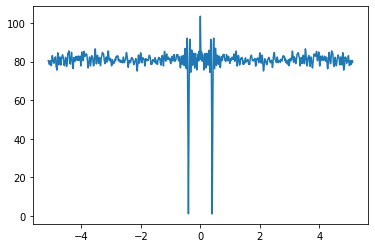

In [44]:
T = np.random.random((1000, 1))*100
T = np.tile(T, (1, 1024))
b2 = F2(T, 0.6, 1.2, 100, 0.4)
A = np.full((1000, 1024), 0.6)
B = np.full((1000, 1024), 1.2)
C = np.full((1000, 1024), 100)
D = np.tile(np.arange(-5.11, 5.13, 0.01), (1000, 1))
y = np.mean(abs(F2(T, A, B, C, D) - b2), axis=0)
# print(np.argmin(y))
smallest_d = round(D[0][np.argmin(y)], 2)
smallest_val = np.mean(abs(F2(T, 0.6, 1.2, 100, smallest_d) - b2))
print(f"Smallest value {smallest_val} when D is:{smallest_d}")
plt.plot(D[0], y)


# 2. Plot A C

(1024, 1024)
(1024, 1024)
(1024, 1024)
Smallest value 37.1529000454897 when A is:5.119999999999782, C is 98


C:\Users\Thinkpad\AppData\Local\Temp/ipykernel_18364/3180272603.py:27: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


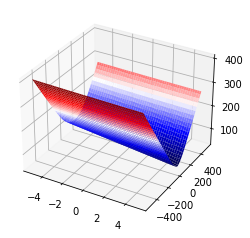

In [45]:
t_shape = (1000, 1024*1024)
T = np.random.random((1000, 1))*100
#T = np.tile(T, (1, 1024, 1024))
b2 = F2(T, 0.6, 1.2, 100, 0.4)
X = np.arange(-5.11, 5.13, 0.01)
Y = np.arange(-511, 513, 1)
X, Y = np.meshgrid(X, Y)
print(X.shape)
print(Y.shape)
Z = np.empty((1024, 1024))
print(Z.shape)
for i in range(1024):
    for j in range(1024):
        ans = F2(T, X[i, j], 0.5, Y[i, j], 0.4)
        Z[i, j] = np.mean(abs(ans - b2))
x, y = np.unravel_index(Z.argmin(), Z.shape)
smallest_val = np.mean(abs(F2(T, X[x, y], 0.5, Y[x, y], 0.4) - b2))
print(f"Smallest value {smallest_val} when A is:{X[x, y]}, C is {Y[x, y]}")
"""
A = np.tile(X, (1000, 1))
B = np.full(t_shape, 1.2)
C = np.tile(Y, (1000, 1))
D = np.full(t_shape, 0.4)
y = np.mean(abs(F2(T, A, B, C, D) - b2), axis=0)
"""
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, Z, cmap="seismic")
plt.show()


# 3. Stock price modeling

In [2]:
import pandas as pd

In [ ]:
def F(t, A, B, C, tc, beta, omega, fi):
    return A + B * (tc - t)**beta * (1 + C*np.cos(omega*np.log(tc - t) + fi))

def gene2coef_stock(gene):
    tc = (np.sum(2**np.arange(10)*gene[0:10]))   #0 - 1023
    beta = (np.sum(2**np.arange(10)*gene[10:20])) / 1023   #0 - 1
    omega = (np.sum(2**np.arange(10)*gene[20:30]) - 511)    #-5.11 - 5.12
    fi = (np.sum(2**np.arange(10)*gene[30:40])) / 1023 * 2*np.pi()   #0 - 2pi
    return tc, beta, omega, fi

def fitness_eval_stock(N, T, b2, pop):
    fit = np.empty([len(pop)])
    for i in range(N):
        tc, beta, omega, fi = gene2coef_stock(pop[i, :])

        # Solve LP
        l = len(T)
        Arr = np.zeros((l, 3))
        for j in range(l):
            Arr[j, 0] = 1
            Arr[j, 1] = (tc-T[j])**beta
            Arr[j, 2] = (tc-T[j])**beta * np.cos(omega*np.log(tc - T[j]) + fi)
        A, B, C = np.linalg.lstsq(A, b2)[0]

        # compute fitness
        fit[i] = np.mean(abs(F(T, A, B, C, tc, beta, omega, fi) - b2))

    return fit



In [ ]:
def gene_algo_stock(b2):

    T = np.arange(len(b2))
    

    N = 10000
    G = 30
    survive_rate = 0.05
    mutation_rate = 0.001
    survive = round(N*survive_rate)
    mutation = round(N*40*mutation_rate)

    pop = np.random.randint(0, 2, (N, 40))
    fit = np.zeros((N, 1))

    for generation in range(G):
    
        # fitness
        fit = fitness_eval_stock(N, T, pop, b2)
        
        #selection
        sortf = np.argsort(fit[:, 0])
        pop = pop[sortf, :]
        for i in range(survive, N):
            fid = np.random.randint(0, survive)
            mid = np.random.randint(0, survive)
            while(fid==mid):
                mid = np.random.randint(0, survive) # mother should different from father
            mask = np.random.randint(0, 2, [1, 40])
            son = pop[mid, :].copy()
            father = pop[fid, :]
            son[mask[0, :]==1] = father[mask[0, :]==1]   # crossover
            pop[i, :] = son
        
        # mutation
        for i in range(mutation):
            m = np.random.randint(survive, N)
            n = np.random.randint(0, 40)
            pop[m, n] = 1 - pop[m, n]

        #fitness
        fit = fitness_eval_stock(N, T, pop, b2)
    
    sortf = np.argsort(fit[:, 0])
    pop = pop[sortf, :]
    
    tc, beta, omega, fi = gene2coef_stock(pop[i, :])

    # Solve LP
    l = len(T)
    Arr = np.zeros((l, 3))
    for j in range(l):
        Arr[j, 0] = 1
        Arr[j, 1] = (tc-T[j])**beta
        Arr[j, 2] = (tc-T[j])**beta * np.cos(omega*np.log(tc - T[j]) + fi)
    A, B, C = np.linalg.lstsq(A, b2)[0]

    predicted = F(A, B, C, tc, beta, omega, fi)
    
    return predicted

In [ ]:
df = pd.read_csv('NVDA.csv', usecols=['Close'])
b2 = df['Close'].to_numpy()
predicted = gene_algo_stock(b2)